In [1]:
pip install fancyimpute xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingRegressor, BaggingClassifier,
    RandomForestRegressor, RandomForestClassifier
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from fancyimpute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from scipy.stats import zscore

# pandas Configuration
pd.options.display.max_columns = 50
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3


# Stellar Signatures: Investigating the Influence of Star Attributes on Exoplanet Properties
## By Molly Stoltz and Hugo Nunez

## Project Overview:
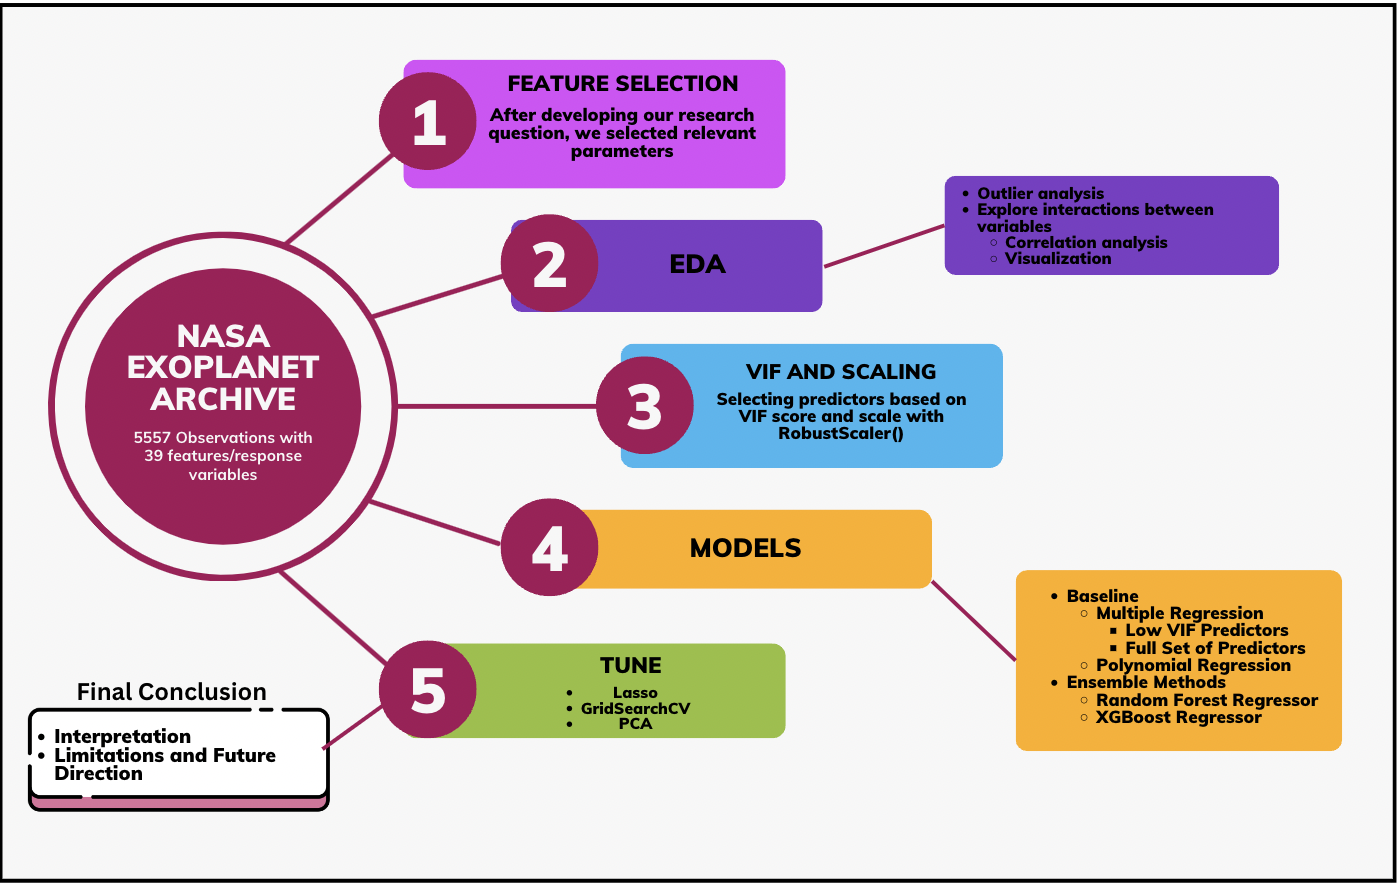

# Variable Definitions
- `loc_rowid`: Identifier for the location of the row in the dataset.
- `pl_name`: Name of the exoplanet.
- `hostname`: Name of the host star where the exoplanet orbits.
- `sy_snum`: Number of stars in the system.
- `sy_pnum`: Number of planets in the star system.
- `discoverymethod`: Method used for discovering the exoplanet.
- `disc_year`: Year of discovery.
- `disc_facility`: Facility or telescope used for discovery.
- `pl_controv_flag`: Flag indicating if the exoplanet is controversial.
- `pl_orbper`: Orbital period of the exoplanet (in days).
- `pl_orbsmax`: Semi-major axis of the exoplanet's orbit (in astronomical units).
- `pl_rade`: Radius of the exoplanet (in Earth radii).
- `pl_radj`: Radius of the exoplanet (in Jupiter radii).
- `pl_bmasse`: Mass of the exoplanet (in Earth masses).
- `pl_bmassj`: Mass of the exoplanet (in Jupiter masses).
- `pl_bmassprov`: Provider of the mass measurement.
- `pl_dens`: Density of the exoplanet (in g/cm³).
- `pl_orbeccen`: Eccentricity of the exoplanet's orbit.
- `pl_insol`: Insolation flux received by the exoplanet (in Earth flux).
- `pl_eqt`: Equilibrium temperature of the exoplanet (in Kelvin).
- `pl_orbincl`: Inclination of the exoplanet's orbit (in degrees).
- `st_spectype`: Spectral type of the host star.
- `st_teff`: Effective temperature of the host star (in Kelvin).
- `st_rad`: Radius of the host star (in solar radii).
- `st_mass`: Mass of the host star (in solar masses).
- `st_met`: Metallicity of the host star.
- `st_metratio`: Ratio of metals in the host star.
- `st_lum`: Luminosity of the host star (in solar luminosities).
- `st_logg`: Surface gravity of the host star (logarithm of cm/s²).
- `st_age`: Age of the host star (in billion years).
- `st_dens`: Density of the host star (in g/cm³).
- `st_vsin`: Rotational velocity of the host star (in km/s).
- `st_rotp`: Rotation period of the host star (in days).
- `st_radv`: Radial velocity of the host star (in km/s).
- `rastr`: Right Ascension coordinate of the star (string format).
- `ra`: Right Ascension coordinate of the star (in degrees).
- `decstr`: Declination coordinate of the star (string format).
- `dec`: Declination coordinate of the star (in degrees).
- `sy_dist`: Distance to the star system (in parsecs).

# Table of Contents
- [Motivation](#Motivation)
- [EDA](#EDA)
  - [Exploring Interactions](#interact)
- [Problem Statement](#Problem-Statement)
- [Models](#models)
  - [Baseline Models](#BaselineModels)
      - [Regression Models](#regressbasic)
      - [Tree Models](#treebasic)
  - [Improved Models](#improve)
- [Conclusion](#interpret)

### Motivation
<a id="Motivation"></a>

Living in such a vast universe, it is easy to become curious about what lies above. With this, we decided to focus our project on the universe outside of CS109A and Earth. Specifically, we hope to investigate the relationship between stars and their planets. Can we predict one's attributes based on another, or do we live in a chaotic unpredictable universe?

Our data source is the NASA Exoplanet Archive, a comprehensive information collection about exoplanets and their host stars. The dataset contains 5557 rows and 39 columns, where each row corresponds to the information of one planet. Details on all of the features can be found in NASA's Exoplanet Archive documentation. Our goal with this dataset is to investigate the influence of star attributes on expo planet properties. We anticipate this data will not be perfect, but let's take a look!

In [3]:
# Import data and take a look at the head
stellar_df = pd.read_csv('data/PSCompPars_2023.11.02_09.23.13.csv')
display(stellar_df.head())
print(stellar_df.columns)

,loc_rowid,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_bmassprov,pl_dens,pl_orbeccen,pl_insol,pl_eqt,pl_orbincl,st_spectype,st_teff,st_rad,st_mass,st_met,st_metratio,st_lum,st_logg,st_age,st_dens,st_vsin,st_rotp,st_radv,rastr,ra,decstr,dec,sy_dist
0,1,11 Com b,11 Com,2,1,Radial Velocity,2007,Xinglong Station,0,323.210,1.178,12.2,1.09,4914.898,15.464,Msini,14.90,0.238,NaN,NaN,NaN,G8 III,4874.0,13.76,2.09,-0.260,[Fe/H],1.978,2.45,NaN,NaN,1.2,NaN,43.37,12h20m42.91s,185.179,+17d47m35.71s,17.793,93.185
1,2,11 UMi b,11 UMi,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,0,516.220,1.530,12.3,1.09,4684.814,14.740,Msini,13.80,0.080,NaN,NaN,NaN,K4 III,4213.0,29.79,2.78,-0.020,[Fe/H],2.430,1.93,1.56,NaN,1.5,NaN,-17.52,15h17m05.90s,229.275,+71d49m26.19s,71.824,125.321
2,3,14 And b,14 And,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,0,186.760,0.775,13.1,1.16,1131.151,3.559,Msini,2.76,0.000,NaN,NaN,NaN,K0 III,4888.0,11.55,1.78,-0.210,[Fe/H],1.840,2.55,4.50,NaN,2.6,NaN,-59.73,23h31m17.80s,352.824,+39d14m09.01s,39.236,75.439
3,4,14 Her b,14 Her,1,2,Radial Velocity,2002,W. M. Keck Observatory,0,1765.039,2.774,12.6,1.12,2559.472,8.053,Mass,7.03,0.373,NaN,NaN,144.652,K0 V,5338.0,0.93,0.91,0.405,[Fe/H],-0.153,4.45,3.90,1.274,1.0,NaN,-13.82,16h10m24.50s,242.602,+43d48m58.90s,43.816,17.932
4,5,16 Cyg B b,16 Cyg B,3,1,Radial Velocity,1996,Multiple Observatories,0,798.500,1.660,13.5,1.20,565.737,1.780,Msini,1.26,0.680,NaN,NaN,NaN,G3 V,5750.0,1.13,1.08,0.060,[Fe/H],0.097,4.36,7.40,1.011,2.7,NaN,-28.10,19h41m51.75s,295.466,+50d31m00.57s,50.517,21.140


Index(['loc_rowid', 'pl_name', 'hostname', 'sy_snum', 'sy_pnum',
       'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag',
       'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse',
       'pl_bmassj', 'pl_bmassprov', 'pl_dens', 'pl_orbeccen', 'pl_insol',
       'pl_eqt', 'pl_orbincl', 'st_spectype', 'st_teff', 'st_rad', 'st_mass',
       'st_met', 'st_metratio', 'st_lum', 'st_logg', 'st_age', 'st_dens',
       'st_vsin', 'st_rotp', 'st_radv', 'rastr', 'ra', 'decstr', 'dec',
       'sy_dist'],
      dtype='object')


Some of these columns are not easily interpretable or able to be modeled well. ra, dec, and their variants are system variables, meaning they are not usable for investigating interactions between stars and their planets. We choose to drop the following columns since we did not see a meaningful way to use them:


'loc_rowid', 'pl_name', 'sy_pnum', 'hostname', 'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag', 'pl_controv_flag', 'pl_bmassprov', 'st_spectype', 'st_metratio', 'ra', 'dec', 'sy_dist', 'rastr', 'decstr'

In [4]:
# Drop the above columns
columns_to_drop = ['loc_rowid', 'pl_name', 'sy_pnum', 'hostname', 'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag', 'pl_controv_flag', 'pl_bmassprov', 'st_spectype', 'st_metratio', 'ra', 'dec', 'sy_dist', 'rastr', 'decstr']
stellar_df.drop(columns=columns_to_drop, inplace=True)

Two observations from the head is that we have systems with multiple stars and columns that appear to have many NaN values. We will address both of these issues. First, let's look at multi star systems.

In [5]:
# Print count of each unique value in sy_snum
unique_counts = stellar_df['sy_snum'].value_counts()
result_df = pd.DataFrame({'sy_snum': unique_counts.index, 'Count': unique_counts.values})
display(result_df)

,sy_snum,Count
0,1,5033
1,2,441
2,3,59
3,4,2


Investigating the count for number of stars in each system, a large majority of our data had only 1 star. Therefore, we chose to analyze single star sysrems, which likely also reduces the confounding effect of two stars in a system. We can drop sy_snum after since it is homogenous across the dataset.

In [6]:
stellar_df = stellar_df[stellar_df['sy_snum'] == 1]
stellar_df.drop(columns=['sy_snum'], inplace=True)

In [7]:
display(stellar_df.head())

,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,pl_orbeccen,pl_insol,pl_eqt,pl_orbincl,st_teff,st_rad,st_mass,st_met,st_lum,st_logg,st_age,st_dens,st_vsin,st_rotp,st_radv
1,516.220,1.530,12.300,1.090,4684.814,14.740,13.80,0.080,NaN,NaN,NaN,4213.0,29.79,2.78,-0.020,2.430,1.93,1.560,NaN,1.50,NaN,-17.52
2,186.760,0.775,13.100,1.160,1131.151,3.559,2.76,0.000,NaN,NaN,NaN,4888.0,11.55,1.78,-0.210,1.840,2.55,4.500,NaN,2.60,NaN,-59.73
3,1765.039,2.774,12.600,1.120,2559.472,8.053,7.03,0.373,NaN,NaN,144.652,5338.0,0.93,0.91,0.405,-0.153,4.45,3.900,1.274,1.00,NaN,-13.82
5,578.380,1.450,12.900,1.150,1373.019,4.320,3.51,0.060,NaN,NaN,NaN,4157.0,25.92,1.22,-0.010,2.254,1.70,5.130,NaN,3.98,329.49,NaN
7,NaN,330.000,18.647,1.664,3000.000,8.000,2.54,NaN,NaN,1700.0,NaN,4060.0,1.31,0.85,NaN,-0.370,4.00,0.005,0.388,NaN,NaN,NaN


Now that we have dealt with multistar systems, let's investigate missignness in our data.

In [8]:
col_missingness_percent = (stellar_df.isna().mean() * 100).sort_values(ascending=False)
print('Percent of NaN values in each column:\n', col_missingness_percent)

Percent of NaN values in each column:
 st_rotp        89.390
st_vsin        68.230
st_radv        63.481
pl_insol       28.671
pl_eqt         24.498
pl_orbincl     22.154
st_age         21.895
pl_orbeccen    14.643
st_dens         8.424
st_met          7.491
pl_orbsmax      5.682
pl_orbper       4.530
st_logg         4.292
st_lum          4.133
st_rad          4.113
st_teff         3.954
pl_dens         2.046
pl_bmassj       0.497
pl_bmasse       0.497
pl_radj         0.338
pl_rade         0.318
st_mass         0.060
dtype: float64


Some of our columns have high percentage of missing values. We decide to drop those above 20% missing and impute the rest.

In [9]:
# Set drop threshold - easily changeable for future work
threshold = 20

# Sdentify the columns to drop based on the previous calculations
columns_to_drop = col_missingness_percent[col_missingness_percent > threshold].index

# Drop the identified columns from the df
stellar_df.drop(columns=columns_to_drop, inplace=True)

# Check new missingness values
col_missingness_percent = (stellar_df.isna().mean() * 100).sort_values(ascending=False)
print('Percent of NaN values in each column:\n', col_missingness_percent.head(20))

Percent of NaN values in each column:
 pl_orbeccen    14.643
st_dens         8.424
st_met          7.491
pl_orbsmax      5.682
pl_orbper       4.530
st_logg         4.292
st_lum          4.133
st_rad          4.113
st_teff         3.954
pl_dens         2.046
pl_bmasse       0.497
pl_bmassj       0.497
pl_radj         0.338
pl_rade         0.318
st_mass         0.060
dtype: float64


Now that we have dropped variables with high missingness, we can go ahead imputing the other data. Since we figure that stellar/planetary features are related for each data point by physical laws, we choose to impute our data using the iterative imputer, which imputes values based on the other values in the row. First, we also should drop the some string columns, since they do not provide meaningful insight and cannot be imputed.

In [10]:
# Instantiate imputer and impute df
imputer = IterativeImputer(random_state=5, max_iter=100)
stellar_df_imputed = pd.DataFrame(imputer.fit_transform(stellar_df), columns=stellar_df.columns)

In [11]:
stellar_df_imputed.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,pl_orbeccen,st_teff,st_rad,st_mass,st_met,st_lum,st_logg,st_dens
0,5.162e+02,1.530,12.300,1.090,4684.814,14.740,13.80,0.080,4213.0,29.79,2.78,-0.020,2.430,1.93,152.893
1,1.868e+02,0.775,13.100,1.160,1131.151,3.559,2.76,0.000,4888.0,11.55,1.78,-0.210,1.840,2.55,38.888
2,1.765e+03,2.774,12.600,1.120,2559.472,8.053,7.03,0.373,5338.0,0.93,0.91,0.405,-0.153,4.45,1.274
3,5.784e+02,1.450,12.900,1.150,1373.019,4.320,3.51,0.060,4157.0,25.92,1.22,-0.010,2.254,1.70,134.991
4,2.065e+07,330.000,18.647,1.664,3000.000,8.000,2.54,0.397,4060.0,1.31,0.85,0.541,-0.370,4.00,0.388


Now that we have dealt with missing data and selected meaningful columns, lets explore the data!

## EDA
<a id="EDA"></a>

Since our project is focused on investigating the relationship between stellar attributes and planetary attributes, our first step is to explore those. However, we should quickly investigate the presence of outliers to help guide our methods.

In [12]:
# Show size of dataframe for reference
print(stellar_df_imputed.shape)

# Helper function for outliers using IQR
def outliers(column):
    # Calculate quartiles
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)

    # Use quartiles to calculate IQR
    IQR = Q3 - Q1

    # Calculate fences using IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers with fences
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return len(outliers)

# Identify outliers for each numeric column in the DataFrame
outliers = stellar_df_imputed.select_dtypes(include='number').apply(outliers)

# Display results
print('Outliers per Column:\n', outliers)

(5033, 15)
Outliers per Column:
 pl_orbper      966
pl_orbsmax     855
pl_rade          9
pl_radj          7
pl_bmasse      952
pl_bmassj      952
pl_dens        223
pl_orbeccen    559
st_teff        273
st_rad         485
st_mass        414
st_met         245
st_lum         334
st_logg        351
st_dens        638
dtype: int64


A few of our columns have a high number of outliers, so we will take that into account during our EDA.

### Exploring Interactions Between Variables
<a id="interact"></a>

We will generate correlation heat maps for planetary attributes, stellar attributes, then correlations between the two. We choose to use spearman correlation, which is a metric less sensitive to outliers. Let's identify our planetary and stellar attributes to investigate them

In [13]:
# Use list comprehension to easily select planetary and stellar attributes
planetary_columns = [col for col in stellar_df_imputed.columns if col.startswith('pl')]
stellar_columns = [col for col in stellar_df_imputed.columns if col.startswith('st')]

# Print the lists out for a sanity check
print(planetary_columns,stellar_columns)

['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens', 'pl_orbeccen'] ['st_teff', 'st_rad', 'st_mass', 'st_met', 'st_lum', 'st_logg', 'st_dens']


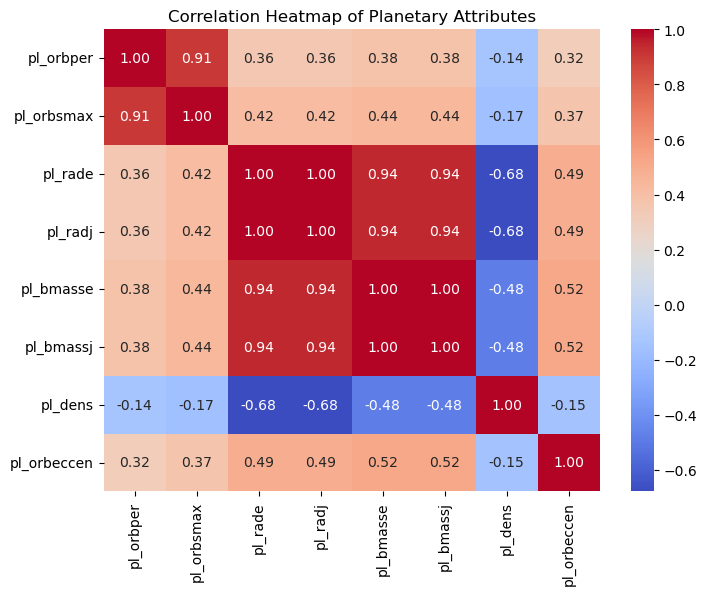

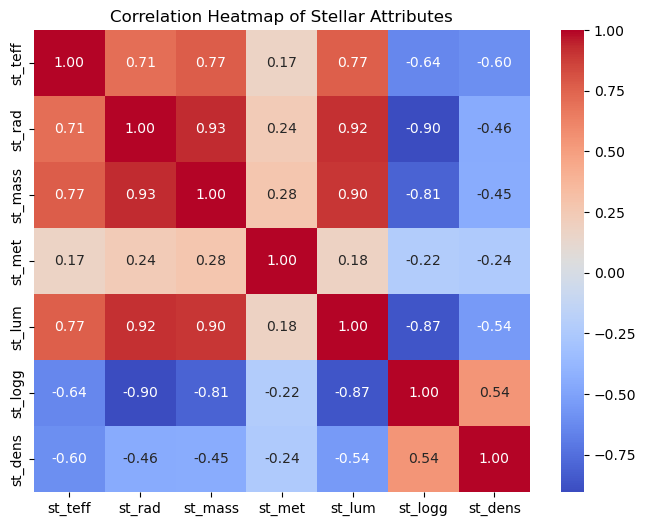

In [14]:
# Calculate correlation matrix for planetary attributes
correlation_matrix_planetary = stellar_df_imputed[planetary_columns].corr(method='spearman')

# Create a heatmap based on correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_planetary, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Planetary Attributes")
plt.show()

# Calculate correlation matrix for stellar attributes
correlation_matrix_stellar = stellar_df_imputed[stellar_columns].corr(method='spearman')

# Create a heatmap based on correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_stellar, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stellar Attributes")
plt.show()

From our first two heatmaps, both stellar and planetary attributes appear highly multicollinear, so we also should evaluate VIF in order to get a better view of the collinearity between features of stellar and planetary data.

Now, we can evaluate planetary vs stellar to find what predictors we may be able to use.

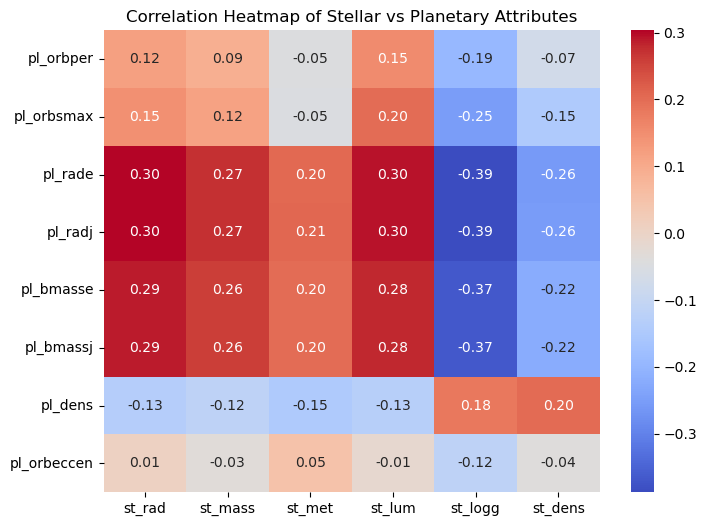

In [15]:
# Combine stellar and planetary attribute dfs
attribute_df = pd.concat([stellar_df_imputed[stellar_columns], stellar_df_imputed[planetary_columns]], axis=1)

# Create correlation matrix of selected attributes
correlation_matrix = attribute_df.corr(method='spearman')

# Select subset to view pl vs st
selected_rows = planetary_columns
selected_columns = stellar_columns[1:]

# Subset the correlation matrix using iloc
subset_corr_matrix = correlation_matrix.loc[selected_rows, selected_columns]

# Create a heatmap based on correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(subset_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stellar vs Planetary Attributes")
plt.show()

From this, we see that planetary radius, mass, orbit, and density have correlations with stellar attributes. 

In [16]:
# Create df with constant to be used in VIF calculation
stellar_attr_df_with_const = pd.concat([pd.Series(1, index=stellar_df_imputed.index, name='const'), stellar_df_imputed[stellar_columns]], axis=1)

# Calculate VIF for each variable
vif_data_stellar = pd.DataFrame()
vif_data_stellar["Variable"] = stellar_attr_df_with_const.columns
vif_data_stellar["VIF"] = [variance_inflation_factor(stellar_attr_df_with_const.values, i) for i in range(stellar_attr_df_with_const.shape[1])]

# Display vif
display(vif_data_stellar)

stellar_attr_df_with_const_planetary = pd.concat([pd.Series(1, index=stellar_df_imputed[planetary_columns].index, name='const'), stellar_df_imputed[planetary_columns]], axis=1)

# Calculate VIF for each variable
vif_data_planetary = pd.DataFrame()
vif_data_planetary["Variable"] = stellar_attr_df_with_const_planetary.columns
vif_data_planetary["VIF"] = [variance_inflation_factor(stellar_attr_df_with_const_planetary.values, i) for i in range(stellar_attr_df_with_const_planetary.shape[1])]
display(vif_data_planetary)

,Variable,VIF
0,const,654.209
1,st_teff,3.647
2,st_rad,39.282
3,st_mass,2.718
4,st_met,1.057
5,st_lum,9.861
6,st_logg,6.763
7,st_dens,24.761


,Variable,VIF
0,const,2.451
1,pl_orbper,3465.371
2,pl_orbsmax,3573.360
3,pl_rade,122.023
4,pl_radj,119.116
5,pl_bmasse,277515.623
6,pl_bmassj,277520.551
7,pl_dens,1.044
8,pl_orbeccen,11.347


Based on both analysis, as well as the definitions, planetary orbper/orbmax and bmasse/bmassj are very similar, so in our analysis, we can model using one of each. For our stellar predictors, we can try to use the low VIF predictors to craft a model as well.

Density has a low VIF, so it could be a useful response. However, high VIF in the response space isn't necessarily bad since they do not model each other.

### Investigating the Data

For this step, we will investigate three possible responses: radius, density, and mass. We chose these three because they are the most understandable and interpretable to people without an astronomy background.

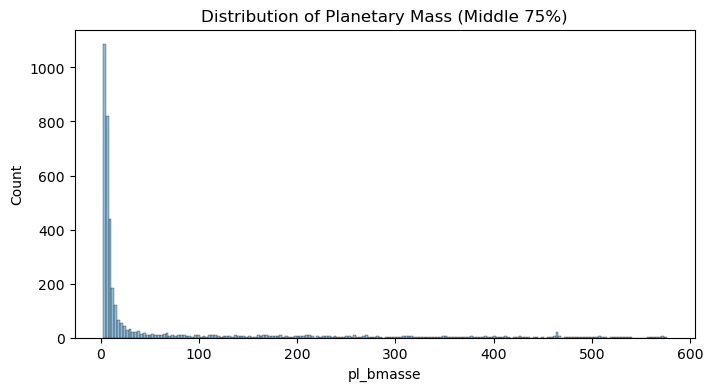

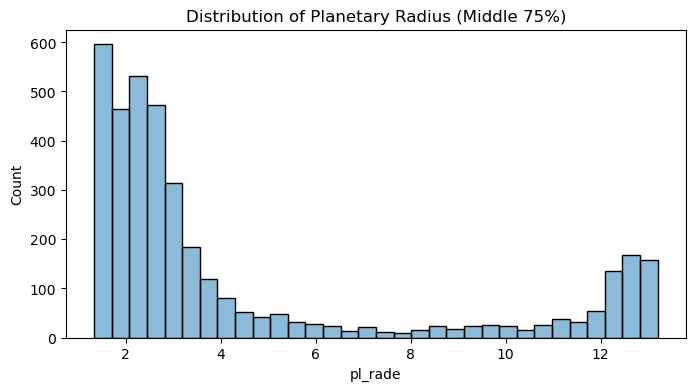

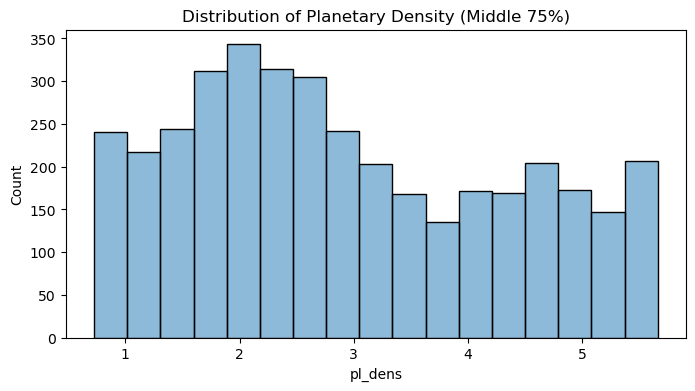

In [17]:
# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_middle_75(data, variable_name, title):
    lower_percentile = np.percentile(data[variable_name], 12.5)  # Lower 12.5% percentile
    upper_percentile = np.percentile(data[variable_name], 87.5)  # Upper 87.5% percentile

    # Filter the data to include only values within the middle 75%
    middle_75_data = data[
        (data[variable_name] >= lower_percentile) &
        (data[variable_name] <= upper_percentile)
    ]

    # Instantiate plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # Create a histogram for the middle 75% of the data
    sns.histplot(data=middle_75_data, x=variable_name, alpha=0.5,
                 stat='count', ax=ax)

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(variable_name)
    ax.set_ylabel('Count')

    # Display the plot
    plt.show()



# Plot for 'pl_bmasse'
plot_middle_75(stellar_df_imputed, 'pl_bmasse', 'Distribution of Planetary Mass (Middle 75%)')

# Plot for 'pl_rade'
plot_middle_75(stellar_df_imputed, 'pl_rade', 'Distribution of Planetary Radius (Middle 75%)')

# Plot for 'pl_orbper'
plot_middle_75(stellar_df_imputed, 'pl_dens', 'Distribution of Planetary Density (Middle 75%)')


We chose to view the middle 75% of the data due to extreme outliers making our graphs unreadable. 
Planetary mass has a cluster of data within the 0-50 range, and then has various samples from 50-600 meaning our data is not normal and may present issues in modeling.
Planetary radius is a bimodal distribution, but there is not a large spread in the data as there was for mass. So, we do not forsee this causing major issues in modeling, aside from the lack of a normal assumption for linear regression.
Density has the most normal distribution and thus, we do not forsee issues modeling density.

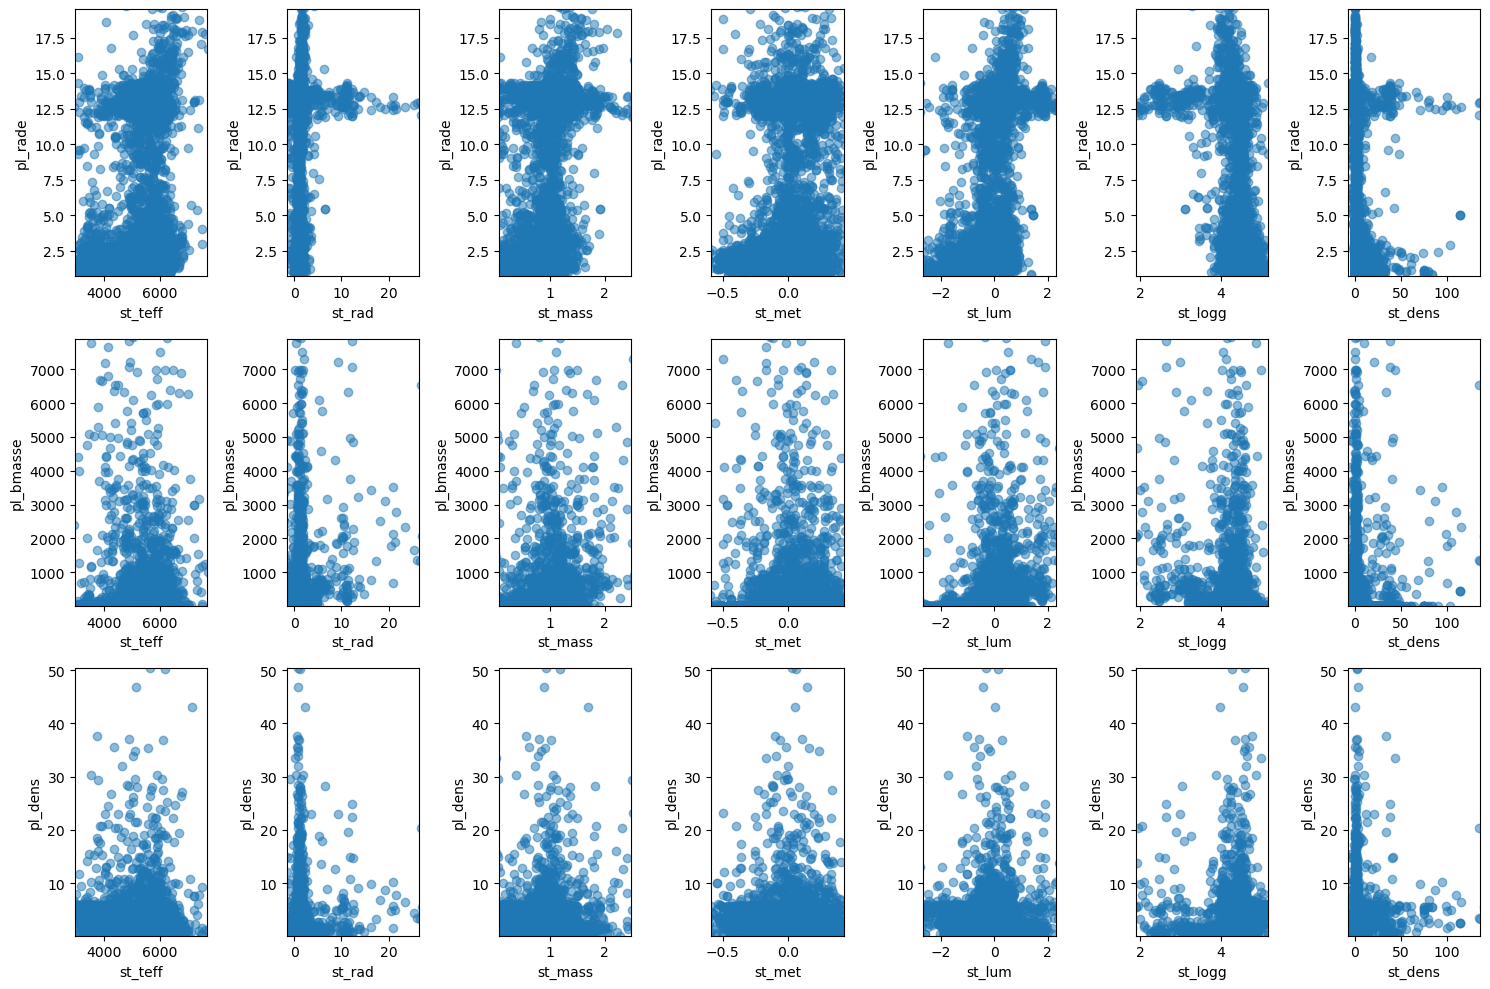

In [18]:
# Identify potential responses, predictors
responses = ['pl_rade', 'pl_bmasse','pl_dens']
predictors = ['st_teff', 'st_rad', 'st_mass', 'st_met', 'st_lum', 'st_logg', 'st_dens']

# Create subplots for each combination of response and predictor
n_responses = len(responses)
n_predictors = len(predictors)

fig, axes = plt.subplots(n_responses, n_predictors, figsize=(15, 10))

# Iterate through responses and predictors
for i, response in enumerate(responses):
    for j, predictor in enumerate(predictors):
        # Scatter plot of response against predictor
        axes[i, j].scatter(stellar_df_imputed[predictor], stellar_df_imputed[response], alpha=0.5)
        axes[i, j].set_xlabel(predictor)
        axes[i, j].set_ylabel(response)


        # View the middle 99% of data due to extreme outliers
        x_min = np.percentile(stellar_df_imputed[predictor], .5)
        x_max = np.percentile(stellar_df_imputed[predictor], 99.5)
        y_min = np.percentile(stellar_df_imputed[response], .5)
        y_max = np.percentile(stellar_df_imputed[response], 99.5)

        # Set x,ylim as specified
        axes[i, j].set_xlim(x_min, x_max)  
        axes[i, j].set_ylim(y_min, y_max)  

# Adjust subplot layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

From graphing our predictors vs responses, after various attempts, we were unable to discern any clear pattern in our data. From this, we expect that linear regression may not perform well, but there is potential for multiple predictors to come together clearly. We will still attempt linear regression since these graphs do not show linear combinations of our 7 predictors.

In our baseline model, we will include three response variables ‘pl_rade’, ‘pl_bmasse’, and ‘pl_dens’. We chose these response variables because they are good representations of the characteristics of a planet. While there are other possible response variables we could have selected, due to the mathematical formulations of them, other response variables are a function of these.

### Problem Statement
For our project, at the most basic level we are investigating how properties of stars and their planets relate. During our initial exploration, we found that there were relationships between a few stellar attributes and planeary ones. 

So, with our model, we aim to predict a planet's attributes based on it's stars attributes. Based on our initial data exploration, we have identified 3 viable response variables: a planet's mass, a planet's radius, and a planet's equilibrium temperature. 

In this notebook, we aim to model these attributes and identify which models and which attributes are viable to model. First, we will start with a linear regression.


# Models
<a id="models"></a>

## <span id="models">Baseline Models</span>

In [19]:
# Create a main dataframe to view all model decisions at the end
results_df_overall = pd.DataFrame(columns=['Model', 'Response', 'MSE', 'R-squared'])

### Regression Models
<a id="regressbasic"></a>

For our models, we will try various models based off of the EDA to predict our response variables. First, we will try a simple linear regression for each response variable based off of all stellar attributes. For the sake of model interpretability, we will scale our data, which will also make it able to be used for our decision trees.

In [20]:
# Set our response variables and our predictors
responses = ['pl_rade', 'pl_bmasse','pl_dens']
predictors = ['st_teff', 'st_rad', 'st_mass', 'st_met', 'st_lum', 'st_logg', 'st_dens']
low_vif_predictors = ['st_teff','st_mass','st_met']

To avoid information leakage when using different predictors, we created a scale function to return our train test split after splitting then scaling and selecting predictors.


In [21]:
def select_scale_split(predictor_columns, response_columns, input_df):
    # Extract predictors and responses from the original dataframe
    X_df = input_df[predictor_columns].copy()
    y_df = input_df[response_columns].copy()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=.8, random_state=5)

    # Scale the data
    scaler_X = RobustScaler()
    X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_df.columns)
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X_df.columns)

    # Scale y again - redundant but easier to use
    scaler_y = RobustScaler()
    y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train), columns=y_train.columns)
    y_test_scaled = pd.DataFrame(scaler_y.transform(y_test), columns=y_test.columns)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled



Our first model will evaluate the low VIF predictors as identified in our EDA. We take a low VIF model approach in order to reduce any error due to multicollinearity.

,Response,MSE,R-squared
0,pl_rade,0.594,4.076e-02
1,pl_bmasse,4475.770,2.341e-04
2,pl_dens,9.198,2.153e-03


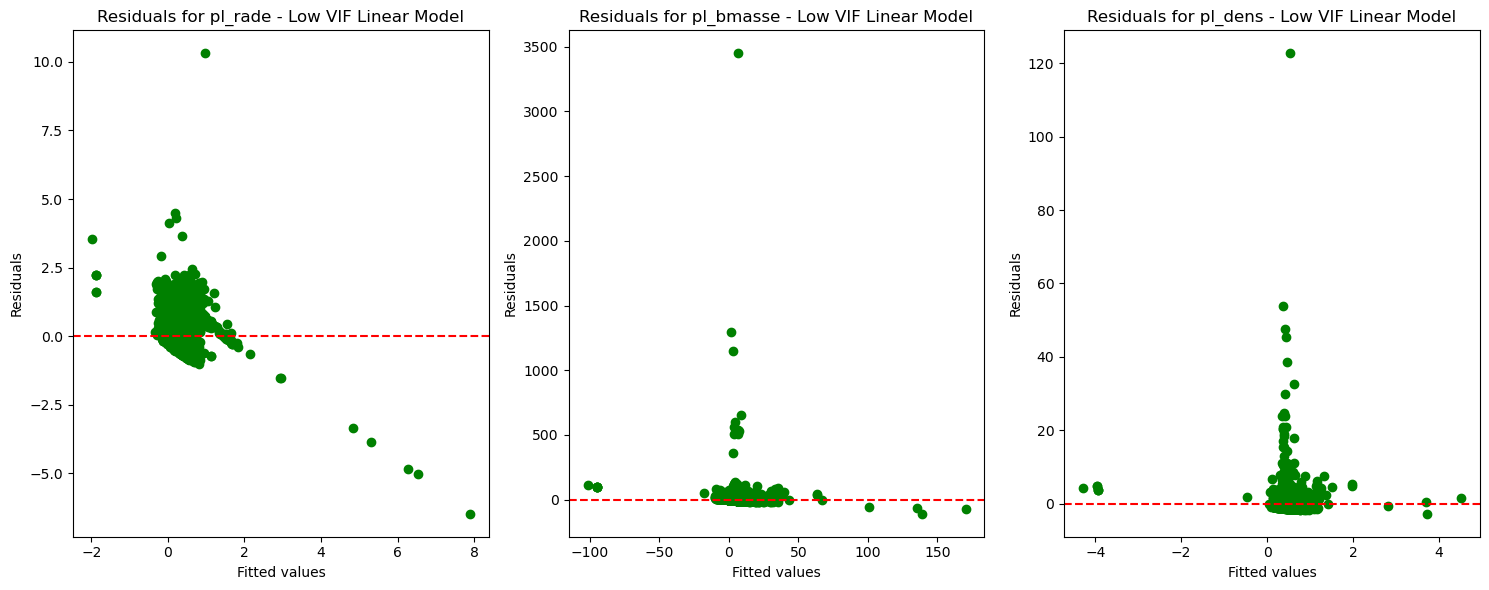

In [22]:
# Select low vif predictors and split on them
X_train, X_test, y_train, y_test = select_scale_split(low_vif_predictors, responses, stellar_df_imputed)

# Set length of response variable to be reused for subplots
n_columns = len(responses)

# Create subplots with one row and n columns
fig, axes = plt.subplots(1, n_columns, figsize=(15, 6))

# Create df for results
results_df = pd.DataFrame(columns=['Response', 'MSE', 'R-squared'])

for i, response in enumerate(responses):
    # Instantiate a linear regression object and fit with train for response
    lreg = LinearRegression()
    lreg.fit(X_train, y_train[response])

    # Use fitted model to generate y preds and calculate residuals
    y_pred = lreg.predict(X_test)
    residuals = y_test[response] - y_pred

    # Scatter plot of residuals
    axes[i].scatter(y_pred, residuals, color="g")

    # Create axis line at y=0
    axes[i].axhline(y=0, color='r', linestyle='--')

    # Set axis labels and title
    axes[i].set_title(f"Residuals for {response} - Low VIF Linear Model")
    axes[i].set_xlabel("Fitted values")
    axes[i].set_ylabel("Residuals")

    # Calculate MSE and R-squared
    mse = mean_squared_error(y_test[response], y_pred)
    r2 = r2_score(y_test[response], y_pred)

    # Create a result row DataFrame and concatenate it with results_df
    result_row = pd.DataFrame({'Response': [response], 'MSE': [mse], 'R-squared': [r2]})
    results_df = pd.concat([results_df, result_row], ignore_index=True)

    # Add to overall dataframe
    result_row_overall = pd.DataFrame({'Model': ['Low VIF Linear Model'], 'Response': [response], 'MSE': [mse], 'R-squared': [r2]})

    # Append the result row to the results DataFrame
    results_df_overall = pd.concat([results_df_overall, result_row_overall], ignore_index=True)
    

# Display results
display(results_df)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

Our models using low VIF predictors displayed high mse and very low $R^2$ values.

The residual models above plot the residuals of our response variable in the low VIF linear model. The first residual plot for ‘pl_rade’ has a cluster of points around Fitted values within the range 0 to 2. Overall, there appears to be a linear relationship between the residuals which is a non-random pattern, suggesting that the relationship between the predictors and response is non-linear. There is also evidence of outliers as there are points far from the majority of other residuals. These data points may have an impact on the regression and may require further investigation in our future analysis. The residual plot for ‘pl_bmasse’ also how a cluster of residuals around the range for fitted values of 0 to 50. There also does not appear to be a random pattern, thus a linear relationship is likely not the correct assumption. Additionally, there is evidence of outliers as there are points that are very different from the majority of residuals. The pattern is similar in the residual plot for ‘pl_dens’. There is a cluster of residuals around Fitted value in the range of 0 to 1. There is a non-random pattern in the residual plot suggesting a non-linear relationship between ‘pl_dens’ and the predictors as well. There is also evidence of outliers


Moving on from our low VIF predictors, we will construct a linear model with the whole selected prediction space.


,Response,MSE,R-squared
0,pl_rade,0.515,0.169
1,pl_bmasse,4433.785,0.010
2,pl_dens,9.166,0.006


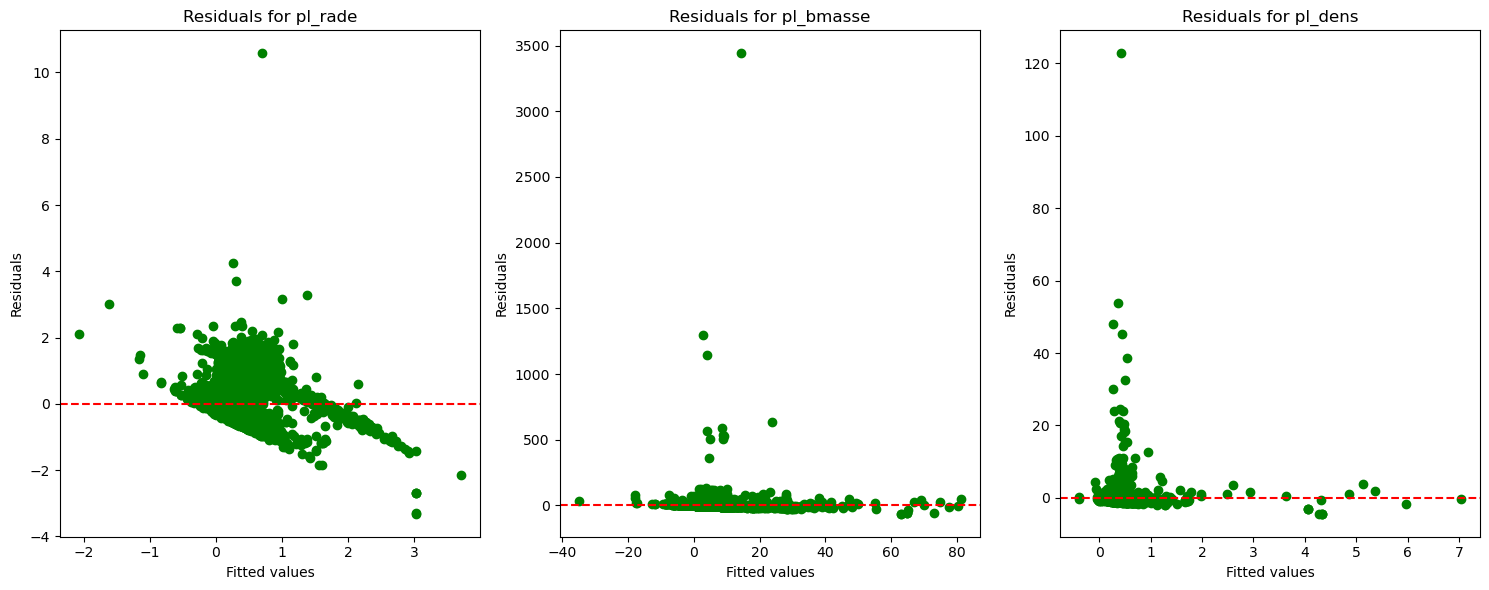

In [23]:
X_train, X_test, y_train, y_test = select_scale_split(predictors, responses, stellar_df_imputed)

fig, axes = plt.subplots(1, n_columns, figsize=(15, 6))

# Create df for results
results_df = pd.DataFrame(columns=['Response', 'MSE', 'R-squared'])

for i, response in enumerate(responses):
    # Instantiate a linear regression object and fit with train for response
    lreg = LinearRegression()
    lreg.fit(X_train, y_train[response])

    # Use fitted model to generate y preds and calculate residuals
    y_pred = lreg.predict(X_test)
    residuals = y_test[response] - y_pred

    # Scatter plot of residuals
    axes[i].scatter(y_pred, residuals, color="g")

    # Create axis line at y=0
    axes[i].axhline(y=0, color='r', linestyle='--')

    # Set axis labels and title
    axes[i].set_title(f"Residuals for {response}")
    axes[i].set_xlabel("Fitted values")
    axes[i].set_ylabel("Residuals")

    # Print MSE and R-squared for model evaluation
    mse = mean_squared_error(y_test[response], y_pred)
    r2 = r2_score(y_test[response], y_pred)

    # Create a result row DataFrame
    result_row = pd.DataFrame({'Response': [response], 'MSE': [mse], 'R-squared': [r2]})
    results_df = pd.concat([results_df, result_row], ignore_index=True)

    # Add to overall dataframe
    result_row_overall = pd.DataFrame({'Model': ['Full Linear Model'], 'Response': [response], 'MSE': [mse], 'R-squared': [r2]})

    # Append the result row to the results DataFrame
    results_df_overall = pd.concat([results_df_overall, result_row_overall], ignore_index=True)


# Display results
display(results_df)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

Using the full feature space with linear regression, we visualized the residuals for each of our response variables to determine whether a linear model is appropriate for our data. The residual plot for ‘pl_rade’ shows a non-random pattern indicating that the model failed to take nonlinear effects into account and a linear regression is not the optimal model. In the residual plot for ‘pl_bmasse’ there appears to be a mostly non-random pattern, suggesting that a linear regression model could be effective in predicting the response. In the residual plot for ‘pl_dens’, there is a mostly random pattern in the residuals with more randomness occurring with higher fitted values. There is a cluster of values at lower fitted values and increasing residuals around fitted values of 0.5. There is evidence of outliers in all three of the residual plots as there are data points that are far from the majority of other residual points. This will need to be accounted for in future analysis and these points may have an impact on the regression. In comparison to our first residual plots for the low VIF residual model, the residual plots show improvement in model selection.


Even using the full feature space with linear regression, we do not acheieve low MSE and high $R^2$, though both metrics improved using the full feature set. Therefore, going forward we will use the full feature set.

Before moving on from regression models, we will verify that there is not a polynomial relationship with our data.

In [24]:
results_df = pd.DataFrame(columns=['Response', 'Best Degree', 'Best MSE', 'Best R-squared'])

for response in responses:
    best_degree = None
    best_mse = float('inf')
    best_r2 = -float('inf')
    X_train, X_val, y_train, y_val = select_scale_split(predictors, responses, stellar_df_imputed)
    for degree in range(1, 10):
        # instantiate polynomial features
        x_poly_train = PolynomialFeatures(degree=degree).fit_transform(X_train)
        x_poly_val = PolynomialFeatures(degree=degree).fit_transform(X_val)

        lreg = LinearRegression(fit_intercept=False)

        # Fit the model on the scaled training data
        lreg.fit(x_poly_train, y_train[response])

        # Predict on the scaled validation data
        y_val_pred = lreg.predict(x_poly_val)

        # Calculate MSE and R-squared on the scaled validation data
        mse_poly = mean_squared_error(y_val[response], y_val_pred)
        r2_poly = r2_score(y_val[response], y_val_pred)

        # Update best_degree, best_mse, and best_r2 if a better result is found
        if mse_poly < best_mse:
            best_degree = degree
            best_mse = mse_poly
            best_r2 = r2_poly

    # Create a result row DataFrame
    result_row = pd.DataFrame({'Response': [response], 'Best Degree': [best_degree], 'Best MSE': [best_mse], 'Best R-squared': [best_r2]})
    results_df = pd.concat([results_df, result_row], ignore_index=True)

# Display results
display(results_df)

,Response,Best Degree,Best MSE,Best R-squared
0,pl_rade,1,0.515,0.169
1,pl_bmasse,1,4433.785,0.010
2,pl_dens,1,9.166,0.006


From the polynomial regression mode, we determined that the best degree model for each of our response variables is degree 1. However, from our prior models we also determined that a linear relationship is not a strong assumption for our data.


Now that we have verified that the linear regression model of degree 1 is the best we can do for a basic regression model, we now move on to trees.

### Tree Models
<a id="treebasic"></a>

For our tree model, we decided to try random forest and xgboost. Given the lack of reliable models based on $R^2$, we figured that a simple decision tree would not be suited for our data. So, we chose one bagging ensemble and one boosting ensemble, with hopes of dealing with our multicollinearity.

In [25]:
results_dfs = []

# Define a list of tree depths to iterate through
tree_depths = [10, 20, 30]

# Model each response
X_train, X_test, y_train, y_test = select_scale_split(predictors, responses, stellar_df_imputed)

for response in responses:
    results_response = []  # List to store results for the current response
    
    for max_depth in tree_depths:
        # Create a RandomForestRegressor with the current max_depth
        rf = RandomForestRegressor(n_estimators=1000, random_state=5, max_features='sqrt', max_depth=max_depth)
        rf.fit(X_train, y_train[response])

        # Generate y predictions with fitted model
        y_pred = rf.predict(X_test)

        # Calculate scoring metrics to evaluate model
        mse = mean_squared_error(y_test[response], y_pred)
        r2 = r2_score(y_test[response], y_pred)

        # Append the results as a dictionary to the list
        results_response.append({'Response': response, 'Tree Depth': max_depth, 'MSE': mse, 'R-squared': r2})
    
    # Create a DataFrame for the current response
    results_df_response = pd.DataFrame(results_response)
    
    # Append the DataFrame to the list of results DataFrames
    results_dfs.append(results_df_response)

    # Add to overall dataframe
    result_row_overall = pd.DataFrame({'Model': ['Random Forest'], 'Response': [response], 'MSE': [mse], 'R-squared': [r2]})

    # Append the result row to the results DataFrame
    results_df_overall = pd.concat([results_df_overall, result_row_overall], ignore_index=True)

# Concatenate all results DataFrames into one DataFrame
results_df = pd.concat(results_dfs, ignore_index=True)

# Print the DataFrame with results
display(results_df)


,Response,Tree Depth,MSE,R-squared
0,pl_rade,10,0.373,0.398
1,pl_rade,20,0.368,0.405
2,pl_rade,30,0.369,0.405
3,pl_bmasse,10,4386.025,0.020
4,pl_bmasse,20,4385.623,0.020
5,pl_bmasse,30,4385.606,0.020
6,pl_dens,10,9.387,-0.018
7,pl_dens,20,9.437,-0.024
8,pl_dens,30,9.459,-0.026


We can see that using a tree model led to much better results. Specifically, 'pl_rade' scored very well both in MSE and $R^2$ relative to the linear models.

In [26]:
learning_rates = [0.2, 0.1, 0.01, 0.001]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Response', 'Learning Rate', 'MSE', 'R-squared'])

# Model each response
for response in responses:
    best_learning_rate = None
    best_mse = float('inf')
    best_r2 = -float('inf')
    
    for learning_rate in learning_rates:
        # Create and fit an XGBoost Regressor with the current learning rate
        xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=learning_rate)
        xgb_model.fit(X_train, y_train[response])

        # Generate y predictions with the fitted model
        y_pred = xgb_model.predict(X_test)

        # Calculate scoring metrics to evaluate model
        mse = mean_squared_error(y_test[response], y_pred)
        r2 = r2_score(y_test[response], y_pred)

        # Check if the current model is better than the best so far
        if mse < best_mse:
            best_mse = mse
            best_r2 = r2
            best_learning_rate = learning_rate

    # Create a result row DataFrame for the best model
    result_row = pd.DataFrame({'Response': [response], 'Learning Rate': [best_learning_rate], 'MSE': [best_mse], 'R-squared': [best_r2]})
    
    # Append the result row to the results DataFrame
    results_df = pd.concat([results_df, result_row], ignore_index=True)

    # Add to overall dataframe
    result_row_overall = pd.DataFrame({'Model': ['XGBoost'], 'Response': [response], 'Learning Rate': [best_learning_rate], 'MSE': [best_mse], 'R-squared': [best_r2]})
    
    # Append the result row to the overall results DataFrame
    results_df_overall = pd.concat([results_df_overall, result_row_overall], ignore_index=True)

# Print the DataFrame with results
display(results_df)


,Response,Learning Rate,MSE,R-squared
0,pl_rade,0.010,0.387,0.375
1,pl_bmasse,0.100,4436.703,0.009
2,pl_dens,0.001,9.953,-0.080


Using XGBoost, we also achieved solid results for radius, and better results for density. 

In [27]:
grouped_results = results_df_overall.groupby('Response')

# Use list comprehension to create a list of DataFrames for each response
response_dataframes = [group for _, group in grouped_results]

# Display all DataFrames at once
[display(df) for df in response_dataframes]

,Model,Response,MSE,R-squared,Learning Rate
1,Low VIF Linear Model,pl_bmasse,4475.770,2.341e-04,NaN
4,Full Linear Model,pl_bmasse,4433.785,9.612e-03,NaN
7,Random Forest,pl_bmasse,4385.606,2.037e-02,NaN
10,XGBoost,pl_bmasse,4436.703,8.961e-03,0.1


,Model,Response,MSE,R-squared,Learning Rate
2,Low VIF Linear Model,pl_dens,9.198,0.002,NaN
5,Full Linear Model,pl_dens,9.166,0.006,NaN
8,Random Forest,pl_dens,9.459,-0.026,NaN
11,XGBoost,pl_dens,9.953,-0.080,0.001


,Model,Response,MSE,R-squared,Learning Rate
0,Low VIF Linear Model,pl_rade,0.594,0.041,NaN
3,Full Linear Model,pl_rade,0.515,0.169,NaN
6,Random Forest,pl_rade,0.369,0.405,NaN
9,XGBoost,pl_rade,0.387,0.375,0.01


[None, None, None]

We can now compare the boosting and bagging ensemble methods based on the MSE and $R^2$ values they produced for each response variable. The MSE for ‘pl_rade’ was lower for the boosting ensemble, but the $R^2$ was also lower for the boosting ensemble. Thus for ‘pl_rade’, the bagging ensemble explains the variance of the data better than the boosting ensemble. However, the boosting ensemble reduces the average squared difference between observed and predicted values. Both of the $R^2$ values for the response ‘pl_bmasse’ were very low, thus for both the boosting and bagging ensemble very little variance of the data is explained. The MSE’s were very similar for both models as well. Finally, the MSE for ‘pl_dens’ was lower in the bagging ensemble than the boosting ensemble while the boosting ensemble better explained the variance of the data.

Due to the very low $R^2$ values for ‘pl_bmasse’ there is not a strong enough correlation between the predictors and the response to be able to build a strong model.

For our XGBoost Model, we naively compared learning rates for each predictor as a first step in building our best model. For radius, .01 appeared the best learning rate while density did best at .1. We will take this into consideration when tuning this model.


Overall, our tree models had much better scoring metrics for radius and density, while mass still is not much improved. For our final models, we will not build models around mass, since it appears to be unexplainable given our data.


## Improving on our Baseline Models
<a id="improve"></a>

Given our baseline models, we will tune these models in order to create the best model for predicting pl_rade (planetary radius), since it is the response variable that universally had the best $R^2$ value.

First, for our linear regression model, we will use LASSO regularization with 5 fold cross validation using the whole feature set. We will use the whole feature set here due to the fact that LASSO regularization will set any irrelevant parameters to 0.

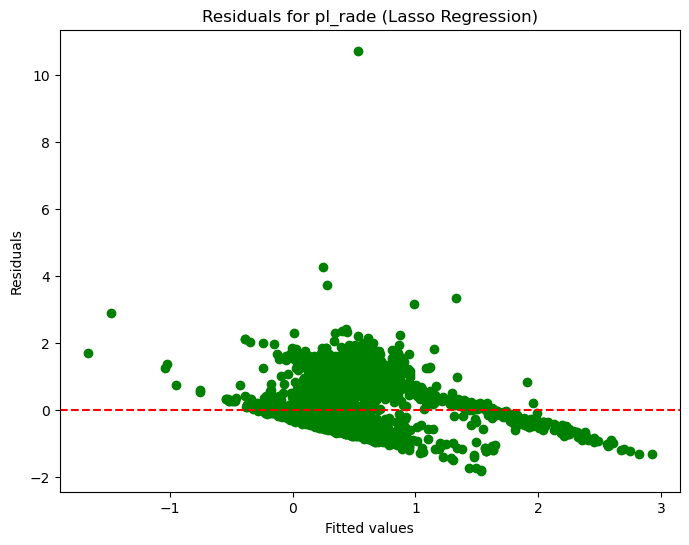

,Response,MSE,R-squared
0,pl_rade,0.501,0.191


In [28]:
X_train, X_test, y_train, y_test = select_scale_split(predictors, ['pl_rade'], stellar_df_imputed)

y_train = y_train['pl_rade'].values.ravel()
y_test = y_test['pl_rade'].values.ravel()

# Use LassoCV for automatic alpha selection
lasso_cv_reg = LassoCV(cv=5, max_iter=100000)
lasso_cv_reg.fit(X_train, y_train)
alpha = lasso_cv_reg.alpha_

# Use the selected alpha to fit the model again
lasso_reg = Lasso(alpha=alpha, max_iter=100000)
lasso_reg.fit(X_train, y_train)

# Predict using the best model
y_pred = lasso_reg.predict(X_test)

# Calculate residuals to plot
residuals = y_test - y_pred

# Scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color="g")

# Create a line at 0
plt.axhline(y=0, color='r', linestyle='--')

# Set axis labels
plt.title(f"Residuals for {'pl_rade'} (Lasso Regression)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# Calculate scores and print
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create a result row DataFrame
result_row = pd.DataFrame({'Response': ['pl_rade'], 'MSE': [mse], 'R-squared': [r2]})

# Display the result
display(result_row) 


After Lasso, the residual plot still has a non-random pattern meaning that the model is still not the best representation of the relationship in the data. However, the $R^2$ value improved as a result of Lasso Regression with interaction terms. We determined that this model is an improvement, but we will attempt pca as a final attempt to handle the multicollinearity among predictors.


In [29]:
best_r2 = float('-inf')
best_mse = float('inf')
best_n_components = None

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['n_components', 'MSE', 'R-squared'])

# Iterate over different values of n_components
for n_components in range(2, 8):
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Apply a regression model (e.g., linear regression) to the transformed data
    regression_model = LinearRegression()
    regression_model.fit(X_train_pca, y_train)

    # Predict using the model
    y_pred = regression_model.predict(X_test_pca)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Create a result row DataFrame
    result_row = pd.DataFrame({'n_components': [n_components], 'MSE': [mse], 'R-squared': [r2]})

    # Concatenate the result row with the results_df
    results_df = pd.concat([results_df, result_row], ignore_index=True)

    # Check if the current model is the best so far
    if r2 > best_r2:
        best_r2 = r2
        best_mse = mse
        best_n_components = n_components


# Display the results DataFrame
display(results_df)

# Print the best performing model
print('\n\n')
print(f'Best performing model has {best_n_components} components:')
print(f'Best PCA regression mse: {best_mse}')
print(f'Best R-squared: {best_r2}')


,n_components,MSE,R-squared
0,2,0.536,0.134
1,3,0.531,0.143
2,4,0.532,0.141
3,5,0.525,0.152
4,6,0.524,0.154
5,7,0.515,0.169





Best performing model has 7 components:
Best PCA regression mse: 0.5145745176390039
Best R-squared: 0.16914632640685345


PCA resulted in a lower $R^2$ value and a higher MSE than the Lasso regression with interaction terms so this is not a proper next step in our model. We will now try to optimize the random forest using GridSearchCV to find the optimal parameter values for our forest, using our baseline model as evidence.


In [30]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 22, 24, 26, 28, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create Random Forest Regressor
rf = RandomForestRegressor(random_state=5)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                            cv=5, scoring='r2', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to train the final model
best_rf = RandomForestRegressor(**best_params, random_state=5)
best_rf.fit(X_train, y_train)

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create a result row DataFrame
result_row = pd.DataFrame({'Model': ['Random Forest'], 'MSE': [mse], 'R-squared': [r2]})

# Display the result
display(result_row) 


,Model,MSE,R-squared
0,Random Forest,0.379,0.387


In [31]:
X_train, X_test, y_train, y_test = select_scale_split(predictors, ['pl_rade', 'pl_dens'], stellar_df_imputed)

# Define hyperparameter grid including regularization parameters
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7, 10]
}

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Response', 'MSE', 'R-squared'])

# Model each response
for response in ['pl_rade', 'pl_dens']:
    xgb_model = xgb.XGBRegressor()

    # Set up the grid search with 5-fold cross-validation
    grid_cv = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

    grid_cv.fit(X_train, y_train[response])

    # Get the best parameters and fit the model
    best_params = grid_cv.best_params_
    xgb_model = xgb.XGBRegressor(**best_params)
    xgb_model.fit(X_train, y_train[response])

    # Generate y predictions with the fitted model
    y_pred = xgb_model.predict(X_test)

    # Calculate scoring metrics
    mse = mean_squared_error(y_test[response], y_pred)
    r2 = r2_score(y_test[response], y_pred)

    # Create a result row DataFrame
    result_row = pd.DataFrame({'Response': [response], 'MSE': [mse], 'R-squared': [r2]})

    # Concatenate the result row with the results_df
    results_df = pd.concat([results_df, result_row], ignore_index=True)


# Display the results DataFrame
display(results_df)


,Response,MSE,R-squared
0,pl_rade,0.386,0.377
1,pl_dens,11.540,-0.252


# Results
<a id="interpret"></a>

Overall, we saw that using a regression model did not explain much of the variance present in our data. When controlling for multicollinearity by using low VIF predictors, we got poor results. Using our full feature set yielded better, but not strong results in our regression models. Even when tuning with Lasso, our best $R^2$ was not high. Overall, our regression results were not meaningful. 

However, our tree models performed quite well relative to our regression models. This was a strength of our project. Specifically for radius, our models were able explain roughly 40% of the variance on either model, which is much better than our regression models. Tuning XGBoost for density strongly increased the model, showing 25% variance explained. However, when we tuned these models for radius, the performance fell. We suspect that this difference was a result of overfitting. Using basic learners and ensemble methods without tuning seemed to produce strong results relevant to the regression models.

We believe that the multicollinearity and the scale of the data were two issues that affected our modeling results. Due to physical laws, we assume that all of our planetary attributes and stellar attributes have a defined relationship, likely nonlinear. These relations led to highly multicollinear data, which led to poor modeling results. 
As for the scale, our data had an immense range, both within and across columns, including extreme outliers. We attempted to address this issue with a robust scaler designed to handle outliers. However, even after scaling this issue persisted. For future projects, selecting a better subset from a larger datasource could result in data on a similar scale. This would reduce or eliminate the issue of extreme outliers, resulting in a more normally distributed dataset that is more in line with the assumptions of linear regression.

By better understanding the laws of astronomy, we believe that more usable predictor and response spaces could be selected. Improved feature selection would reduce multicollinearity and improve the results of our model. Going forward, tree models should be a focus of this exploration as shown by their high performance in this project.

Thanks for reading and for all the help along the way!

Enjoy your holiday,

Molly and Hugo